# Исследование продаж видеоигр

В данной работе анализируются и исследуются исторические данные из открытых источников о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). В ходе работы будут выявляться определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.



### Открытие файла с данными и изучение общей информации
#### Открытие файла

In [1]:
import pandas as pd
from scipy import stats as st

In [2]:
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

#### Вывод первых строчек датафрейма

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#### Общая информация о датафрейме

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод раздела.** В данном разделе был подключен датафрейм, а также получены основные представления о том, как выглядят данные, для будущей работы.

### Предобработка данных
#### Замена названий столбцов
Можно заметить, что все названия столбцов содержат заглавные буквы. Их будет неудобно использовать, поэтому привожу все буквы к нижнему регистру.

In [5]:
data.columns = data.columns.str.lower()

#### Обработка пропусков
Для начала стоит узнать сколько пропусков в каждом столбце

In [6]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [7]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,1.600000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.300000
user_score,40.100000


В столбцах имя и жанр по два пропуска. Ниже представлены строки с ними

In [8]:
data[(data['name'].isna()) | (data['genre'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Строки жанра игры можно было бы заполнить вручную, найдя информацию об игре в интернете, но отсутствие названия продукта мешает это сделать, поэтому просто удаляю их.

In [9]:
data = data[~data['name'].isna()]

Из-за малого количества пропусков в столбце `year_of_release`: 1.6% от общего количества данных. Их тоже стоит удалить

In [10]:
data = data[~data['year_of_release'].isna()].reset_index(drop=True)

В столбце `user_score` встречается значение `tbd`, что означает `To Be Determined`, т.к. игра ещё не выпущена

In [11]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Заменю все эти значения на nan

In [12]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

В столбце Rating неизвестные значения заменю на `Unknown`.

In [13]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [14]:
data['rating'] = data['rating'].fillna('Unknown')

#### Удаление дубликатов
Вывод явных дубликатов

In [15]:
data.duplicated().sum()

0

Попробую привести все текстовые значения в данных к нижнему регистру и проверить их уникальные значения, чтобы убедиться в отсутствии неявных дубликатов.

In [16]:
check_duplicates_data = data.copy()
check_duplicates_data['name'] = check_duplicates_data['name'].str.lower()
check_duplicates_data['platform'] = check_duplicates_data['platform'].str.lower()
print('Уникальные значения "platform"\n', sorted(check_duplicates_data['platform'].unique()))
check_duplicates_data['genre'] = check_duplicates_data['genre'].str.lower()
print('Уникальные значения "genre"\n', sorted(check_duplicates_data['genre'].unique()))
check_duplicates_data['rating'] = check_duplicates_data['rating'].str.lower()
print('Уникальные значения "rating"\n', sorted(check_duplicates_data['rating'].unique()))
print('Количество дубликатов', check_duplicates_data.duplicated().sum())
del check_duplicates_data

Уникальные значения "platform"
 ['2600', '3do', '3ds', 'dc', 'ds', 'gb', 'gba', 'gc', 'gen', 'gg', 'n64', 'nes', 'ng', 'pc', 'pcfx', 'ps', 'ps2', 'ps3', 'ps4', 'psp', 'psv', 'sat', 'scd', 'snes', 'tg16', 'wii', 'wiiu', 'ws', 'x360', 'xb', 'xone']
Уникальные значения "genre"
 ['action', 'adventure', 'fighting', 'misc', 'platform', 'puzzle', 'racing', 'role-playing', 'shooter', 'simulation', 'sports', 'strategy']
Уникальные значения "rating"
 ['ao', 'e', 'e10+', 'ec', 'k-a', 'm', 'rp', 't', 'unknown']
Количество дубликатов 0


В текстовых значениях неявных дубликатов не наблюдается, а после приведения всех текстовых значений к нижнему регистру явные дубликаты так и не удалось обнаружить.

#### Изменение типов данных
Год релиза игры - это всегда целое число, поэтому все числа стоит привести к типу `integer` для экономии памяти. Критики оценивают игры по 100 бальной шкале, а пользователи по 10-ти бальной, поэтому для удобного сравнения этих оценок приведу все оценки к 10-ти бальной шкале.

In [17]:
data['year_of_release'] = pd.to_numeric(data['year_of_release'], downcast='integer')
data['critic_score'] = data['critic_score'].round() / 10
data['user_score'] = data['user_score'].round(1)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int16  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int16(1), object(4)
memory usage: 1.3+ MB


#### Создание столбца с суммой всех продаж
В предоставленном датафрейме количество продаж разделено на регионы. Для будущего анализа необходим столбец, в котором будет содержаться общая сумма проданных копий.

In [19]:
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

**Вывод раздела.** В данном разделе была проведена обработка данных, в которую входили такие процессы как:
+ замена наименований столбцов;
+ обработка пропусков;
+ проверка дубликатов в данных;
+ изменение типов данных в столбцах;
+ создание нового столбца.

Все эти процессы упростят работу с данными в дальнейшем.

### Исследовательский анализ данных

#### Выпуск игр в разные годы
Для наглядного представления о количестве выпущенных игр в разные годы строю гистограмму.

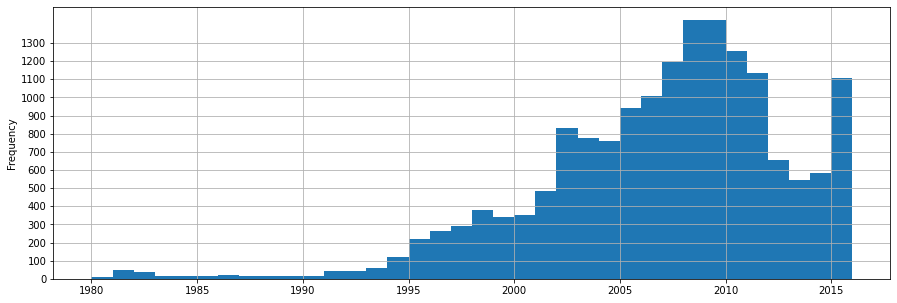

In [20]:
data['year_of_release'].plot(kind='hist', bins=36, grid='True', figsize=(15,5), yticks=[tick for tick in range(0, 1400, 100)]);

На гистрограмме видно, что до 1994 года выпускалось меньше 100 игр на всех платформах. Такой выборки недостаточно для анализа, поэтому удаляю все данные до 1994 года.

In [21]:
data = data[data['year_of_release'] >= 1994].reset_index(drop=True)

**Вывод.** На основе данного анализа данных было выявлено, что данные до 1994 года обладают слишком маленькой выборкой.

#### Продажи на игровых платформах в разные годы
В датафрейме представлено большое количество разных игровых платформ. Отбираю самые популярные платформы, чтобы график в дальнейшем было удобно читать.

In [22]:
top_platforms = data.groupby('platform')['all_sales'].sum().sort_values(ascending=False).head(10)
top_platforms

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: all_sales, dtype: float64

Строю график, на котором каждый столбец - это суммарные продажи всех популярных платформ.

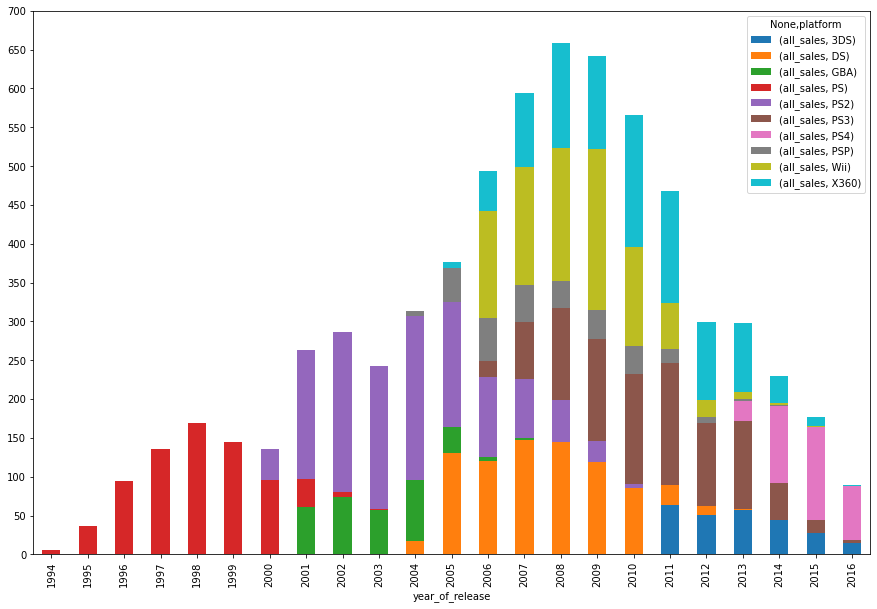

In [23]:
platform_sales_table = data[data['platform'].isin(top_platforms.index)].pivot_table(
    index=['year_of_release', 'platform'],
    values='all_sales',
    aggfunc='sum'
)
platform_sales_table.unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(15, 10),
    yticks=[tick for tick in range(0, 701, 50)]
);

Этот график отлично показывает, что большинство платформ актуальны примерно в течении 10 лет. Для дальнейшего анализа возьму последние три года, так как под конец 2013 года появляется PS4 на смену PS3. Стоит также отметить, что серия платформ PS из топ 10 самых популярных платформ занимает целых 5 строчек (PS, PS2, PS3, PS4, PSP). Интересно также то, что 4 строчки в топе занимают портативные приставки (3DS, DS, GBA, PSP).

**Вывод.** На основе данного анализа данных был выявлен примерный срок жизни платформы (10 лет) и актуальный период для будущего анализа (2014-2016 годы).

#### Анализ продаж в актуальный период
В этот раз анализирую популярные платформы с 2014 по 2016 годы.

In [24]:
actual_data = data[data['year_of_release'] >= 2014].reset_index(drop=True)
top_platforms = actual_data.groupby('platform')['all_sales'].sum().sort_values(ascending=False)
top_platforms

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
WiiU     42.98
PC       27.05
PSV      22.40
Wii       5.07
PSP       0.36
Name: all_sales, dtype: float64

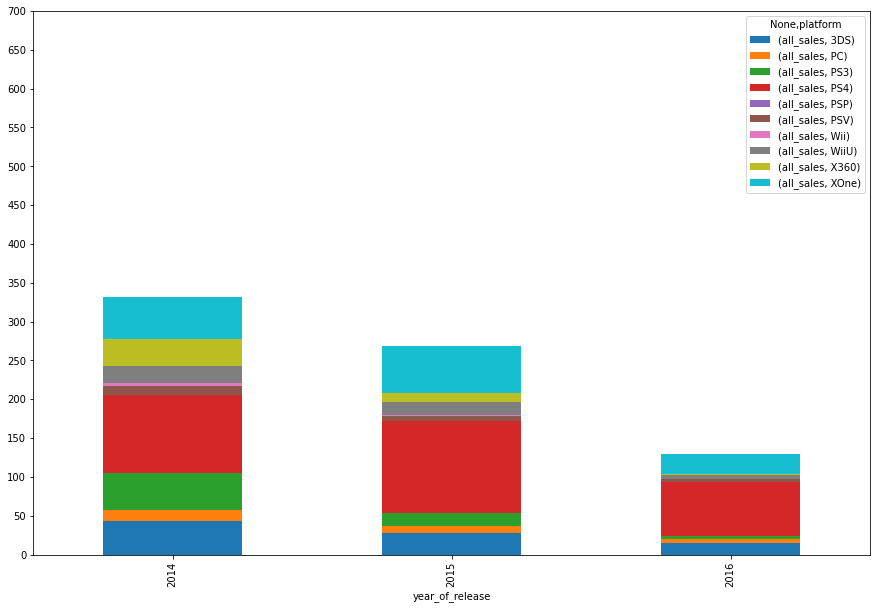

In [25]:
platform_sales_table = actual_data[actual_data['platform'].isin(top_platforms.index)].pivot_table(
    index=['year_of_release', 'platform'],
    values='all_sales',
    aggfunc='sum'
)
platform_sales_table.unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(15, 10),
    yticks=[tick for tick in range(0, 701, 50)]
);

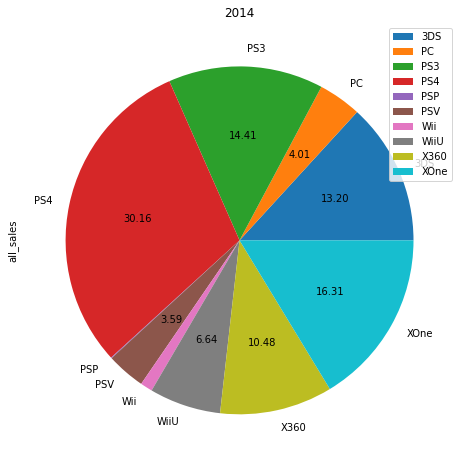

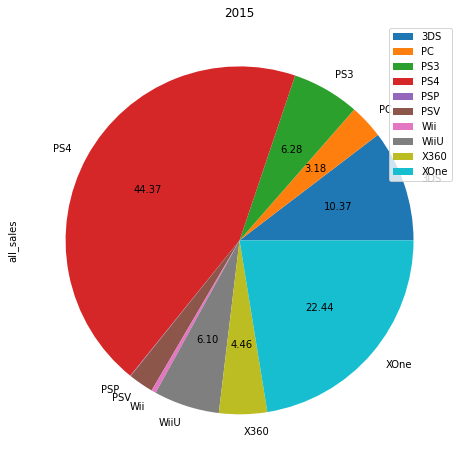

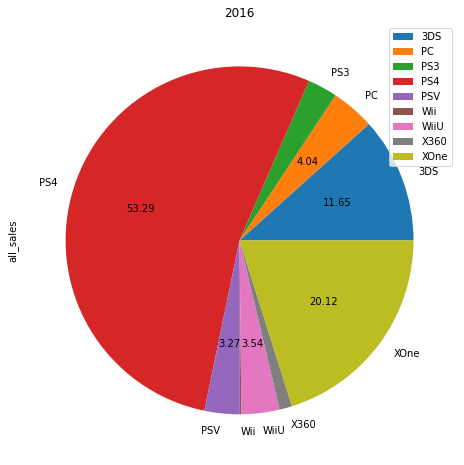

In [26]:
def autopct(pct):
    return ('%.2f' % pct) if pct > 3 else ''

platform_sales_table.loc[2014, :].plot(kind='pie', y='all_sales', figsize=(15, 8), title='2014', autopct=autopct);
platform_sales_table.loc[2015, :].plot(kind='pie', y='all_sales', figsize=(15, 8), title='2015', autopct=autopct);
platform_sales_table.loc[2016, :].plot(kind='pie', y='all_sales', figsize=(15, 8), title='2016', autopct=autopct);

На момент 2016 года продажи на платформе PS4 составляют более 50% от всех продаж. Доля PS4 выросла на 23% с 2014 года, хотя и сам рынок упал. Для продаж на 3DS выросла на 1%, но упала на 2% с 2014 года. а доля продаж на XOne упала на 2%. PSV и WiiU в 2016 году получили по 3%. Доля PC составила 4% в 2016 году. Такой же показатель у PC был в 2014, однако в 2015 году у PC всего 3%. X360 и PS3 стабильно теряют долю продаж с 2014 года. На основе этих данных стоит убрать лишние платформы в данном десятилетии, так как их популярность идёт на спад.

In [27]:
actual_data = actual_data[actual_data['platform'].isin(['PS4', 'PC', '3DS', 'XOne', 'WiiU', 'PSV'])]

**Вывод.** В данной части анализа были выявлены актуальные платформы на момент 2016-го. Самой популярной платформой для игр является PS4, так как у неё доля продаж составляет 53.29%. Актуальнымы платформами также будут PC (4.04%), 3DS (11.65%), XOne (20.12%), WiiU (3.54%) и PSV (3.27%).

#### Анализ разброса данных по актуальным платформам
Для анализа разброса данных будет построен график "Ящик с усами".

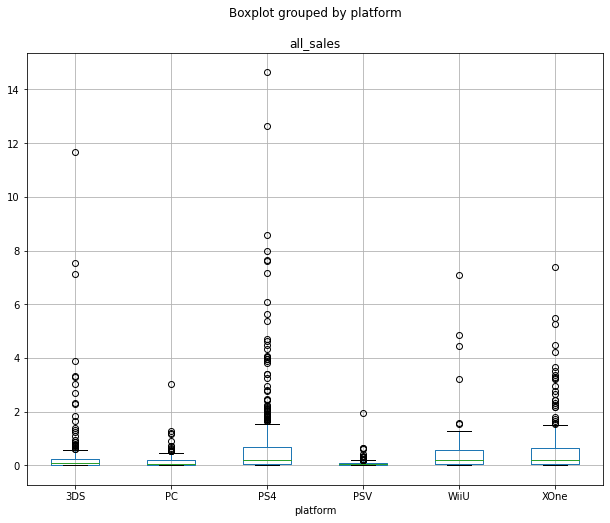

In [28]:
actual_data.boxplot(column='all_sales', by='platform', figsize=(10, 8));

Приближенный график

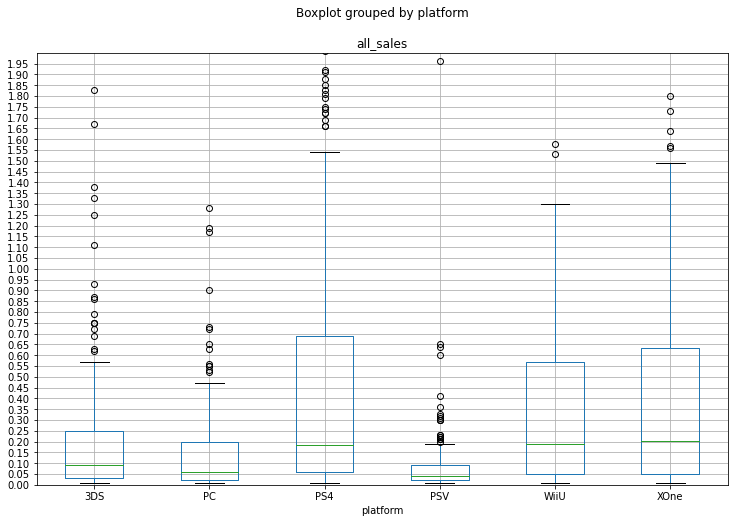

In [29]:
ax = actual_data.boxplot(column='all_sales', by='platform', figsize=(12, 8));
ax.set_ylim(0, 2);
ax.set_yticks([tick / 100 for tick in range(0, 200, 5)]);

Данный график показывает, что игры для портативных консолей продаются очень плохо. Верхний ус игр для 3DS доходит примерно только до 0.6 млн копий, а у PSV он не доходит и до 0.2 млн. У PC тоже всё плохо, так как верхний ус находится между 0.45 и 0.5 млн. Остаются только большие консоли. У WiiU верхний ус доходит до 1.3 млн, у XOne - почти до 1.5 млн, а у PS4 почти доходит до 1.55 млн. Хотя у WiiU разброс данных меньше чем у PS4 и XOne, медиана у всех трёх платформ находится примерно на одном уровне - 0.2 млн. Оставлю три платформы в актуальных данных.

In [30]:
actual_data = actual_data[actual_data['platform'].isin(['PS4', 'XOne', 'WiiU'])]

**Вывод.** Данный анализ показывает, что игры на портативных приставках (3DS, PSV) и ПК (PC) продаются хуже, чем на больших консолях (PS4, WiiU, XOne). Примерно половина продуктов на больших консолях продают хотя бы 200 тысяч раз.

#### Взаимосвязь между продажами на разных платформах и отзывами критиков и пользователей
Зависимость продаж от отзывов игроков на PS4

Корреляция -0.031957110204556376


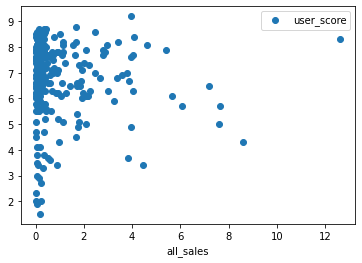

In [31]:
ps4_data = data[data['platform'] == 'PS4']
ps4_data.plot(x='all_sales', y='user_score', style='o');
print('Корреляция', ps4_data['all_sales'].corr(ps4_data['user_score']))

Зависимость продаж от отзывов критиков на PS4

Корреляция 0.4065679020617812


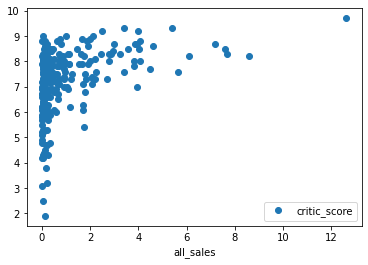

In [32]:
ps4_data.plot(x='all_sales', y='critic_score', style='o');
print('Корреляция', ps4_data['all_sales'].corr(ps4_data['critic_score']))

На графиках видно, что небольшая зависимость продаж от оценок критиков присутствует, так как у игр с большими продажами нет плохих оценок от критиков. Для дальнейших выводов рассмотрю другие платформы.

Зависимость продаж от отзывов игроков на WiiU

Корреляция 0.4002190202148617


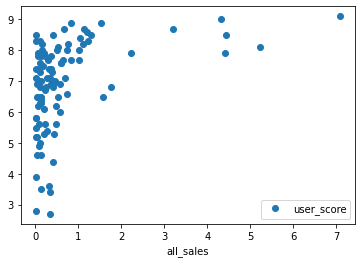

In [33]:
wii_data = data[data['platform'] == 'WiiU']
wii_data.plot(x='all_sales', y='user_score', style='o');
print('Корреляция', wii_data['all_sales'].corr(wii_data['user_score']))

Здесь корреляция иная. Но данных по играм, продажи которых превышают хотя бы 2 млн копий слишком мало.

Зависимость продаж от отзывов критиков на WiiU

Корреляция 0.3483797601201745


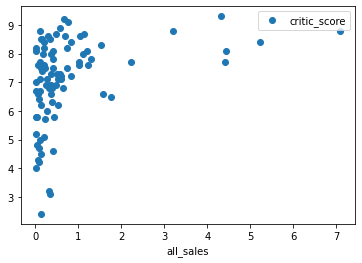

In [34]:
wii_data.plot(x='all_sales', y='critic_score', style='o');
print('Корреляция', wii_data['all_sales'].corr(wii_data['critic_score']))

Зависимость продаж от отзывов игроков на XOne

Корреляция -0.06892505328279412


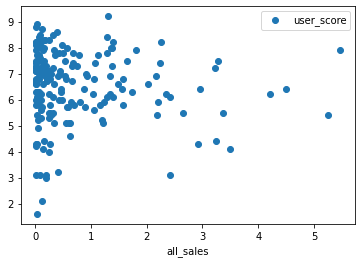

In [35]:
xone_data = data[data['platform'] == 'XOne']
xone_data.plot(x='all_sales', y='user_score', style='o');
print('Корреляция', xone_data['all_sales'].corr(xone_data['user_score']))

Зависимость продаж от отзывов критиков на XOne

Корреляция 0.4169983280084022


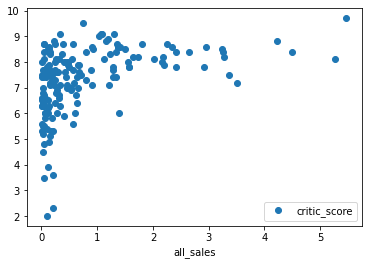

In [36]:
xone_data.plot(x='all_sales', y='critic_score', style='o');
print('Корреляция', xone_data['all_sales'].corr(xone_data['critic_score']))

**Вывод.** Рассматривая эти данные, можно однозначно сказать, что зависимости между отзывами игроков и продажами нет, так как корреляция на платформах PS4 и XOne в таких случаях стремится к нулю. Между оценками критиков и продажами удалось обнаружить минимальную зависимость: игры с большими продажами обычно не получают плохих оценок.

#### Анализ прибильности жанров
Для анализа популярности жанров выведу разброс данных по продажам игр в каждом жанре, выпущенных за 2014-2016 годы.

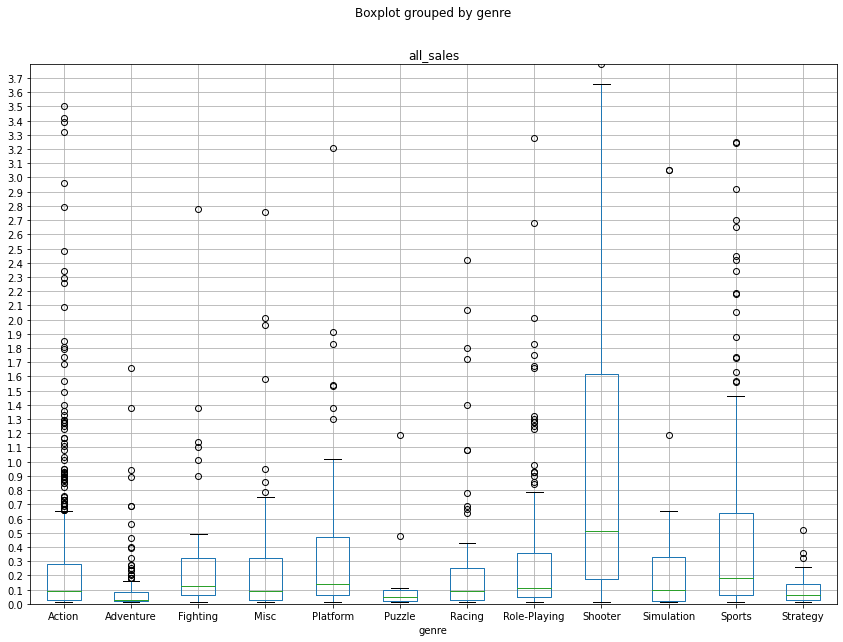

In [37]:
actual_data = data[data['year_of_release'] >= 2014]
ax = actual_data.boxplot(column='all_sales', by='genre', figsize=(14, 10));
ax.set_ylim(0, 3.8);
ax.set_yticks([tick / 100 for tick in range(0, 380, 10)]);

На данном графике можно сразу же заметить, что жанр Shooter в последнее время очень хорошо продаётся. Его медиана равна 500 тысяч, а верхний ус находится на отметке выше 3.6 млн копий. Совсем неприбыльными жанрами можно считать Strategy, Adventure и Puzzle, так как их верний ус находиться на отметке примерно 250 тысяч или ниже. Игры жанров Fighting и Racing также неприбыльные, так как их верхний ус находится на отметке в 500 тысяч. У жанров Action и Simulation похожие показатели (верхний ус: 650 тысяч, медиана: 100 тысяч). У жанров Misc и Role-Playing тоже почти схожие показатели (показатели Role-playing чуть лучше: верхний ус - примерно 750 тысяч, медиана - 100 тысяч). Жанр Platform имеет верхний ус около 1 млн, а медиану на отметке примерно в 150 тысяч. У жанра Sports верхний ус почти доходит до 1.5 млн, а медиана почти доходит до 200 тысяч.

**Вывод.** Исходя из этих данных можно составить список прибыльных жанров с 2014 по 2016 годы:
+ Shooter (верхний ус - 3.6 млн, медиана - 0.5 млн);
+ Sports (верхний ус - почти 1.5 млн, медиана - почти 0.2 млн);
+ Platform (верхний ус - 1 млн, медиана - 0.15 млн);
+ Role-playing (верхний ус - чуть выше 0.75 млн, медиана - чуть выше 0.1 млн);
+ Misc (верхний ус - 0.75 млн, медиана - 0.1 млн).

**Вывод раздела.** Анализируя данные в этом разделе, я выявил, что записей про игры до 1994 года слишком мало, поэтому отбросил их. Далее был определён примерный срок жизни платформ - примерно 10 лет. На основе этих данных был выявлен актуальный период 2010-2016 годы для прогноза данных на будущий год. Опираясь на актуальные период были выбраны актуальные платформы на текущее время (PS4, PC, 3DS, XOne, WiiU, PSV). Для этих платформ был построен график "ящик с усами" и, опираясь на этот график, я отбросил неприбыльные платформы (PC, 3DS, PSV) и оставил прибыльные (PS4, XOne, WiiU). С прибыльными платформами выявлялась взаимосвязь между продажами и оценками пользователей и критиков. Исследование показало, что продажи не зависят от оценок пользователей, но могут немного зависеть от оценок критиков. Под конец раздела были выявлены прибыльные жанры (Shooter, Sports, Platform, Role-Playing и Misc).

### Анализ пользователей различных регионов
#### Популярные платформы
Для дальнейшей работы понадобятся данные за 2016 год.

In [38]:
actual_data = data[data['year_of_release'] >= 2014]

Для определения популярных платформ в разных регионах я сгруппировал продажи в этих регионах по платформам.

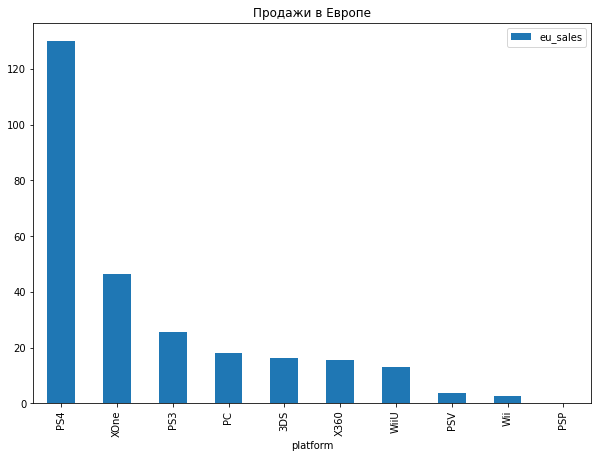

In [39]:
group_region_sales_by_platforms = actual_data.pivot_table(
    index='platform',
    values=['na_sales', 'eu_sales', 'jp_sales'],
    aggfunc='sum'
)

group_region_sales_by_platforms.sort_values(
    by='eu_sales', ascending=False
).plot(kind='bar', y='eu_sales', title='Продажи в Европе' , figsize=(10, 7));

Также я найду долю продаж для каждой из платформ.

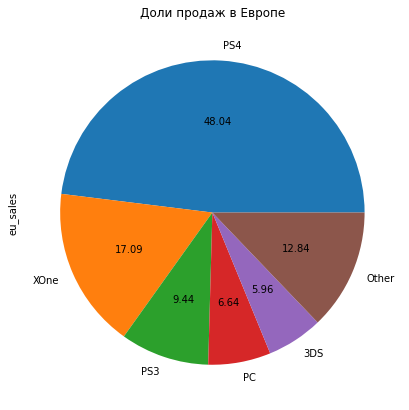

In [40]:
def get_top_with_other(region):
    top = group_region_sales_by_platforms.sort_values(
    by=region, ascending=False)
    return pd.concat([top.head(5)[region], pd.Series([top.reset_index().loc[5:, region].sum()], index=['Other'], name=region)])

get_top_with_other('eu_sales').plot(kind='pie', y='eu_sales', autopct=autopct, title='Доли продаж в Европе' , figsize=(10, 7));

Самая популярная платформа в Европе - PS4. Она имеет 48.04% от всех продаж. Процент продаж на XOne сильно меньше и составляет почти 17.09%. Некоторые пользователи на момент 2014 года всё ещё покупают игры для PS3 - 9.44%. PC и 3DS имеют 6.64%% и 5.96% соответственно. Все остальные платформы в сумме составляют 12.84% продаж.

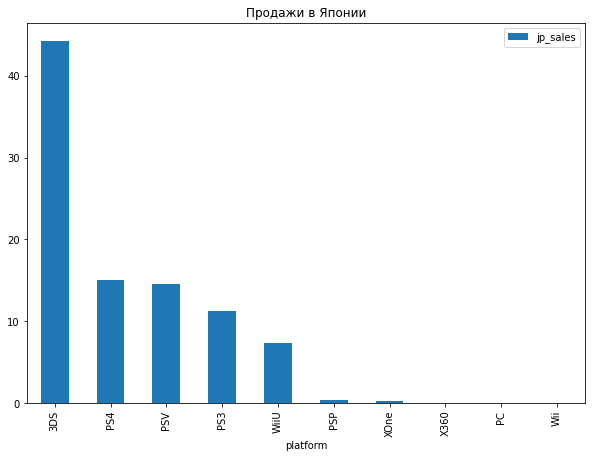

In [41]:
group_region_sales_by_platforms.sort_values(
    by='jp_sales', ascending=False
).plot(kind='bar', y='jp_sales', title='Продажи в Японии' , figsize=(10, 7));

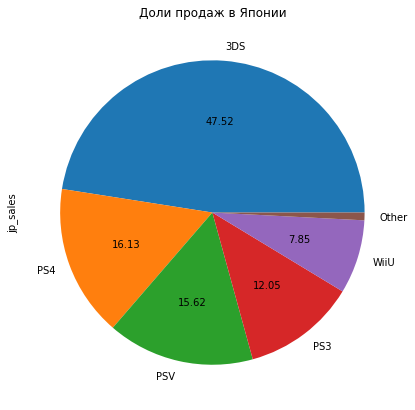

In [42]:
get_top_with_other('jp_sales').plot(kind='pie', y='jp_sales', autopct=autopct, title='Доли продаж в Японии', figsize=(10, 7));

Японцы почти не используют консоли серии Xbox, и наоборот любят консоли серии PS так как из серии PS в топе 3 платформы (PS4 - 16.13%, PSV - 15.62% и PS3 - 12.05%). Также японцы любят портативные приставки, так как 3DS держит первое место с долей продаж 47.52%, в топе есть портативная PSV, о которой говорилось ранее и на barplot графике видно, что в 2014 году, в Японии всё ещё кто-то пользуется PSP. На приставку WiiU приходится 7.85% от доли продаж. Доля продаж всех остальных платформ незначительна.

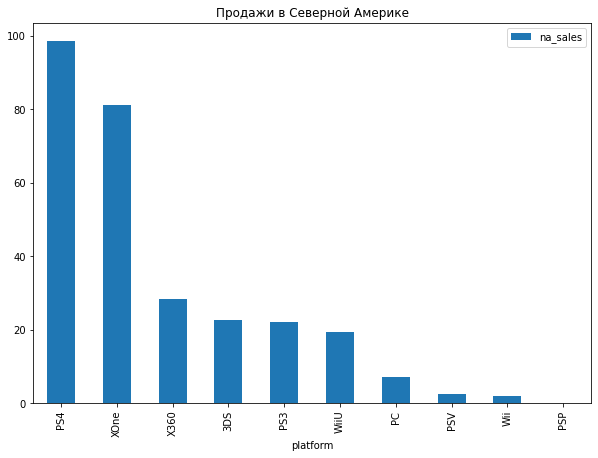

In [43]:
group_region_sales_by_platforms.sort_values(
    by='na_sales', ascending=False
).plot(kind='bar', y='na_sales', title='Продажи в Северной Америке' , figsize=(10, 7));

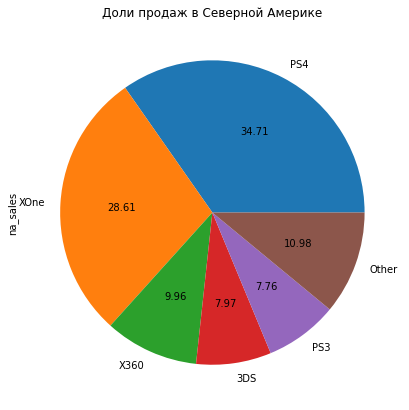

In [44]:
get_top_with_other('na_sales').plot(
    kind='pie', y='na_sales', autopct=autopct, title='Доли продаж в Северной Америке', figsize=(10, 7)
);

В северной Америке самой популярной платформой является PS4. Доля этой платформы на рынке составляет 34.71%. Доля XOne чуть меньше и равняется 28.61%. Старое поколение консолей X360 и PS3 имеют 9.96% и 7.76% соответственно, а у платформы 3DS - 7.97%. Остальные платформы делят между собой 10.98%.

**Вывод.** Платформы PS4 и 3DS так или иначе пользуются популярностью во всех регионах. В Европе и северной Америке PS4 - платформа с самой большой долей продаж (48.04% и 34.71% соответственно). Самая популярная консоль в Япониии - 3DS (47.52%).

#### Популярные жанры
Чтобы выявить популярные жанры в разных регионах необходимо провести аналогичную работу.

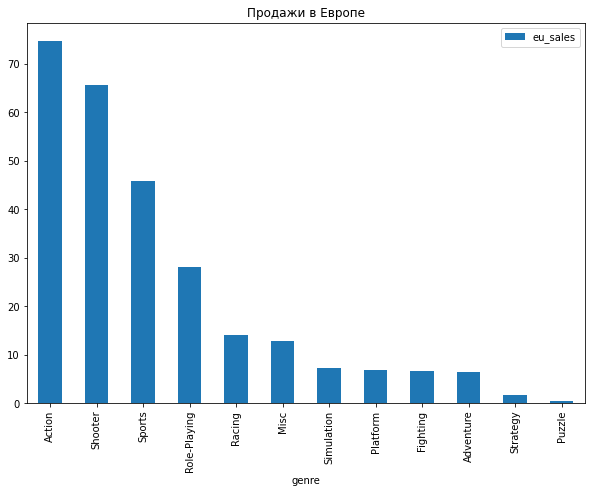

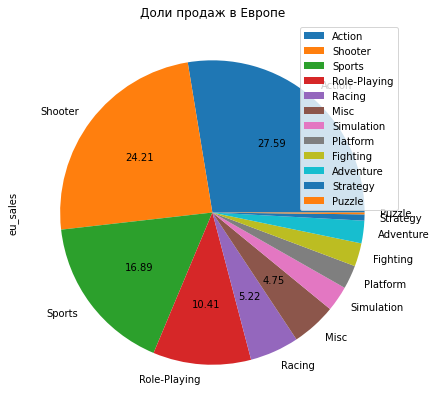

In [45]:
group_region_sales_by_genres = actual_data.pivot_table(
    index='genre',
    values=['na_sales', 'eu_sales', 'jp_sales'],
    aggfunc='sum'
)
group_region_sales_by_genres.sort_values(
    by='eu_sales', ascending=False
).plot(kind='bar', y='eu_sales', title='Продажи в Европе' , figsize=(10, 7));
group_region_sales_by_genres.sort_values(
    by='eu_sales', ascending=False
).plot(kind='pie', y='eu_sales', autopct=autopct, title='Доли продаж в Европе' , figsize=(10, 7));

На графике 27.59% продаж в Европе составляют игры жанра Action. У жанра Shooter - 24.21%. Доля продаж жанра Sports 16.89%. Жанр Role-playing имеет 10.41% продаж, а у жанра Racing 5.22%.

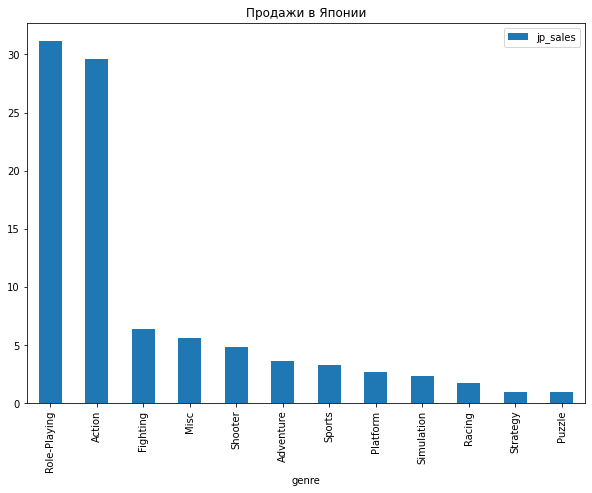

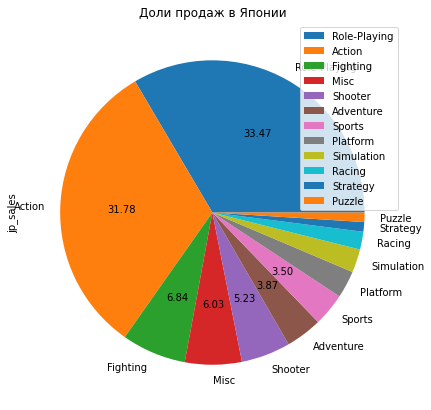

In [46]:
group_region_sales_by_genres.sort_values(
    by='jp_sales', ascending=False
).plot(kind='bar', y='jp_sales', title='Продажи в Японии' , figsize=(10, 7));
group_region_sales_by_genres.sort_values(
    by='jp_sales', ascending=False
).plot(kind='pie', y='jp_sales', autopct=autopct, title='Доли продаж в Японии' , figsize=(10, 7));

В Японии самым продаваемым жанром будет Role-playing. Доля его продаж составляет 33.47%. Жанр Action имеет 31.78%. У жанра Fighting - 6.84%, а у жанра Misc - 6.03%. Замыкает пятёрку жанр Shooter с 5.23%.

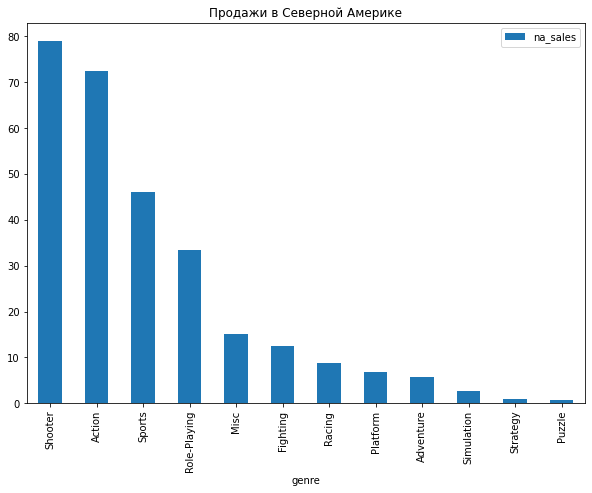

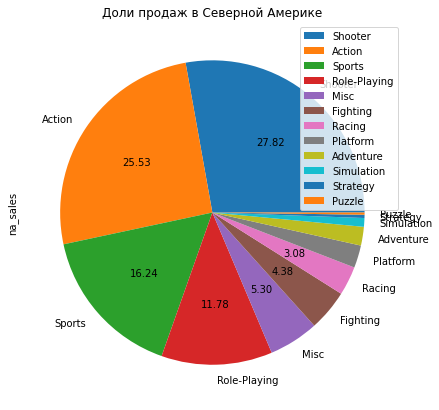

In [47]:
group_region_sales_by_genres.sort_values(
    by='na_sales', ascending=False
).plot(kind='bar', y='na_sales', title='Продажи в Северной Америке' , figsize=(10, 7));
group_region_sales_by_genres.sort_values(
    by='na_sales', ascending=False
).plot(kind='pie', y='na_sales', autopct=autopct, title='Доли продаж в Северной Америке' , figsize=(10, 7));

Топ-5 северной Америки немного похож на топ-5 Европы. Немного отличаются лишь позиции в топе и процентное соотношение, а также жанра Racing не попал в топ, вместо него жанр Misc. Жанр Shooter - самый продаваемый (27.82%). У жанра Action доля продаж составляет 25.53%. Жанр Sports забирает себе 16.24% доли продаж. У жанров Role-playing и Misc доля продаж равна 11.78% и 5.3% соответственно.

**Вывод.** В Европе и северной Америке популярностью пользуются похожие жанры. В Японии жанровые предпочтения имеют отличия от остального мира.

#### Влияние возрастного рейтинга на продажи
Пояснение значений:
+ E (everyone) - контент для всех возрастов
+ EC (early childhood) - контент для дошкольников
+ E10+ (Everyone 10+) - контент для всех возрастов от 10 лет
+ T (Teen 13+) - контент для подростоков от 13 лет
+ M (Mature 17+) - контент для подростков от 17 лет
+ AO (Adults Only 18+) - контент только для взрослых от 18 лет
+ RP (Rating Pending) - рейтинг не назначен

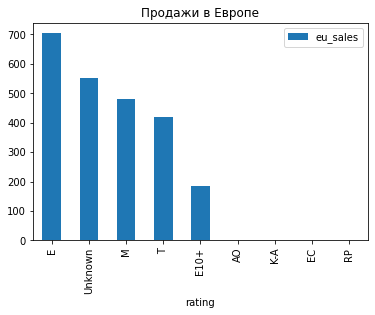

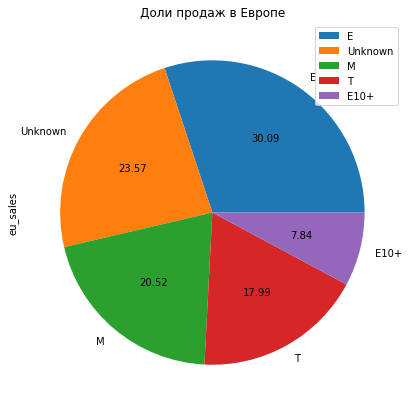

In [48]:
group_region_sales_by_rating = data.pivot_table(
    index='rating',
    values=['na_sales', 'eu_sales', 'jp_sales'],
    aggfunc='sum'
)
group_region_sales_by_rating.sort_values(by='eu_sales', ascending=False).plot(
    kind='bar', y='eu_sales', title='Продажи в Европе'
);
group_region_sales_by_rating.sort_values(by='eu_sales', ascending=False).head(5).plot(
    kind='pie', y='eu_sales', autopct=autopct, title='Доли продаж в Европе' , figsize=(10, 7)
);

Игры с рейтингом `E` имеют 30.09% от всех продаж в Европе.  У игр с рейтингом `M` 20.52% продаж. Игры с рейтингом `Т` имеют долю чуть поменьше - 17.99%. У игр с рейтингом `E10+` самая маленькая доля - 7.84%, если не считать категории с недостаточной выборкой. Процент продаж игр с неизвестным рейтингом - 23.57%.

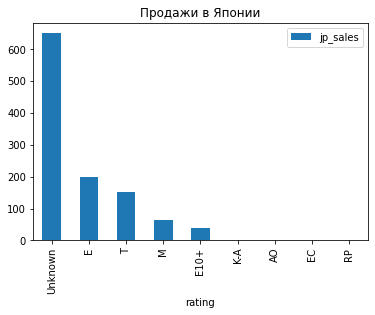

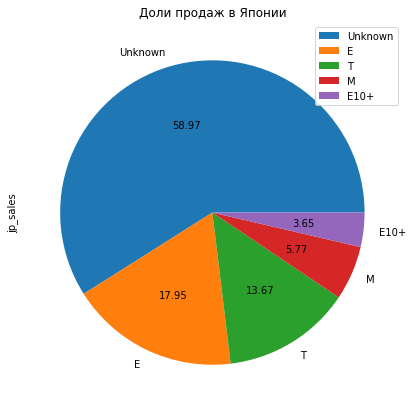

In [49]:
group_region_sales_by_rating.sort_values(by='jp_sales', ascending=False).plot(
    kind='bar', y='jp_sales', title='Продажи в Японии'
);
group_region_sales_by_rating.sort_values(by='jp_sales', ascending=False).head(5).plot(
    kind='pie', y='jp_sales', autopct=autopct, title='Доли продаж в Японии' , figsize=(10, 7)
);

В Японии игры для подростков от 17 лет не пользуются большой популярностью. Доля продаж составляет всего 5.77%. Процент продаж игр с неизвестным рейтингом невероятно большой - 58.97%. Игры для всех охватывают долю продаж - 17.95%. У игр возрастной категории `T` доля продаж - 13.67%, а у игр возрастной категории `E10+` - 5.77%.

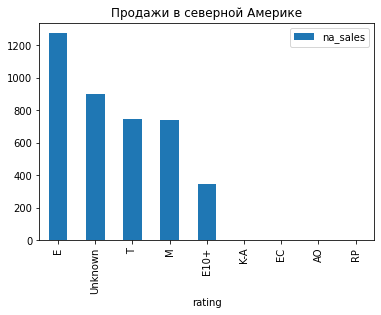

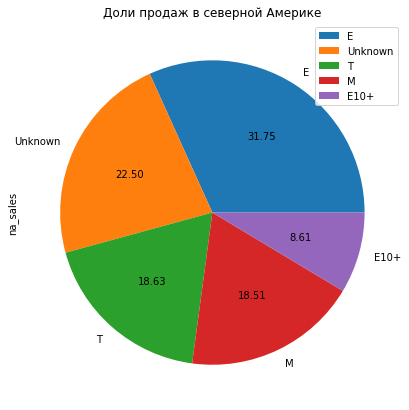

In [50]:
group_region_sales_by_rating.sort_values(by='na_sales', ascending=False).plot(
    kind='bar', y='na_sales', title='Продажи в северной Америке'
);
group_region_sales_by_rating.sort_values(by='na_sales', ascending=False).head(5).plot(
    kind='pie', y='na_sales', autopct=autopct, title='Доли продаж в северной Америке' , figsize=(10, 7)
);

В северной Америке игры для всех также имеют самую большую долю продаж - 31.75%. У игр для подростков от 13 и от 17 примерно по 18.5%, а у игр с возсрастным ограничением 10+ всего 8.61%. Процент продаж игр с неизвестным рейтингом - 22.5%.

**Вывод.** Самыми продаваемыми в Европе и северной Америке будут игры для всех возрастных категорий. У таких игр примерно 30% доли продаж в этих регионах. В Японии почти 60% игр не имеют рейтинга ESRB, так как он предназначен для маркировки игр в США и Канаде, поэтому в северной Америке процент продаж игр с неизвестным рейтингом ниже, чем в остальных регионах. В Японии большой популярностью не будут пользоваться игры рассчитанные на подростков от 17 лет (доля продаж всего 5.77%).

**Вывод раздела.** В этом разделе был составлен портрет пользователя каждого региона. Для этого были составлены топы популярных платформ и популярных жанров, а также изучено влияние рейтинга ESRB в разных регионах. Краткие результаты приведены ниже. Места перечислены в порядке убывания.

Топ популярных платформ.
+ В Европе: PS4 (48.04%), XOne (17.09%), PS3 (9.44%), PC (6.64%), 3DS (5.96%).
+ В Японии: 3DS (47.52%), PS4 (16.13%), PSV (15.62%), PS3 (12.05%), WiiU (7.85%).
+ В северной Америке: PS4 (34.71%), XOne (28.61%), X360 (9.96%), 3DS (7.97%), PS3 (7.76%).

Топ популярных жанров.
+ В Европе: Action (27.59%), Shooter (24.21%), Sports (16.89%), Role-Playing (10.41%), Racing (5.22%).
+ В Японии: Role-Playing (33.47%), Action (31.78%), Fighting (6.84%), Misc (6.03%), Shooter (5.23%).
+ В северной Америке: Shooter (27.82%), Action (25.53%), Sports (16.24%), Role-Playing (11.78%), Misc (5.3%).

Доли продаж по рейтингу ESRB.
+ В Европе: E (30.09%), M (20.52%), T (17.99%), E10+ (7.84%), Unknown (23.57%).
+ В Японии: E (17.95%), T (13.67%), M (5.77%), E10+ (3.65%), Unknown (58.97%).
+ В северной Америке: E (31.75%), T (18.63%), M (18.51%), E10+ (8.61%), Unknown (22.5%).

### Проверка гипотез
#### Рейтинги платформ Xbox One и PC
Проверка гипотезы: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
```
H_0: Пользовательские рейтинги (user_score) платформы "Xbox One" = пользовательские рейтинги (user_score) платформы "PC"
H_1: Пользовательские рейтинги (user_score) платформы "Xbox One" ≠ пользовательские рейтинги (user_score) платформы "PC"
alpha = 0.05
```
Для проверки гипотезы я буду использовать функцию библиотеки scipy для проверки гипотезы о равенстве двух генеральных совокупностей.

Сначала оставляю в data актуальные данные, а затем создаю две группы пользовательских рейтингов и вывожу количество записей в них, чтобы определить размерность выборок.

In [51]:
data = data[data['year_of_release'] >= 2014]
xbox_one_user_score = data[(data['platform'] == 'XOne') & (~data['user_score'].isna())]['user_score']
print('Количество оценок пользователей на Xbox One:', len(xbox_one_user_score))
pc_user_score = data[(data['platform'] == 'PC') & (~data['user_score'].isna())]['user_score']
print('Количество оценок пользователей на PC:', len(pc_user_score))

Количество оценок пользователей на Xbox One: 165
Количество оценок пользователей на PC: 122


Считаю p-значение и на основе него принимаю решение.

In [52]:
alpha = 0.05
results = st.ttest_ind(xbox_one_user_score, pc_user_score)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


**Вывод.** Не получилось отвергнуть нулевую гипотезу, так как p-значение больше заданного порога alpha на 5%. Из этого следует, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

#### Рейтинги жанров Action и Sports
Проверка гипотезы: cредние пользовательские рейтинги жанров Action и Sports разные.
```
H_0: Пользовательские рейтинги (user_score) жанра "Action" = пользовательские рейтинги (user_score) жанра "Sports"
H_1: Пользовательские рейтинги (user_score) жанра "Action" ≠ пользовательские рейтинги (user_score) жанра "Sports"
alpha = 0.05
```

Создаю две группы пользовательских рейтингов и вывожу количество записей в них, чтобы определить размерность выборок.

In [53]:
action_user_score = data[(data['genre'] == 'Action') & (~data['user_score'].isna())]['user_score']
print('Количество оценок пользователей для жанра Action:', len(action_user_score))
sports_user_score = data[(data['genre'] == 'Sports') & (~data['user_score'].isna())]['user_score']
print('Количество оценок пользователей для жанра Sports:', len(sports_user_score))

Количество оценок пользователей для жанра Action: 297
Количество оценок пользователей для жанра Sports: 127


Считаю p-значение и на основе него принимаю решение.

In [54]:
alpha = 0.05
results = st.ttest_ind(action_user_score, sports_user_score, equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


**Вывод.** P-значение оказалось значительно ниже 1%, а значит можно с уверенностью отвергнуть нулевую гипотезу. Из этого следует, что cредние пользовательские рейтинги жанров Action и Sports разные.

**Вывод раздела.** В данном разделе проверяются гипотезы:
+ Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
+ Средние пользовательские рейтинги жанров Action и Sports разные.

При проверке обоих гипотез используется функция для проверки равенства двух генеральных совкупностей. Пороговое значение alpha в обоих случаях равняется 5%. Проверка первой гипотезы показала, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые (p-значение: 0.10450507919348415). Проверка второй гипотезы показала, что cредние пользовательские рейтинги жанров Action и Sports разные (p-значение: 1.1825550382644557e-14).

### Общий вывод
В данной работе проводились исследования данных о продажах игр, оценки пользователей и экспертов, жанры и платформы.

В ходе выполнения проекта были выполнены задачи:
+ Открыт файл с данными и изучена общаю информация;
+ Выполнена предобработка данных (заполнение пустых значений, изменение типов данных, переименование столбцов);
+ Добавлены новые столбцы в таблицу (общее количество проданных копий игры);
+ Проведён исследовательский анализ данных (изучен выпуск игр в разные годы, найден актуальный период и актуальные платформы для предсказаний на будущий год, проанализированы продажи в актуальный период на актуальных платформах, проанализирована взаимосвязь между продажами на разных платформах и отзывами критиков и пользователей и исследованы популярные жанры (в регионах и в мире), популярные платформы (в различных регионах), а также влияние возрастного рейтинга на продажи в регионах).
+ Были проверены гипотезы о равенстве пользователские оценок на платформах Xbox One и PC и о неравенстве пользовательских оценок для игр жанров Action и Sports.

По итогам данной работы я делаю следующие выводы.
+ Данные имеют маленькую выборку до 1994 года.
+ Средний срок жизни игровой платформы - 10 лет.
+ Актуальный период для предсказаний 2017 года - 2014-2016 годы.
+ Актуальные игровые платформы на 2016 год: PS4 (53.29%), PC (4.04%), 3DS (11.65%), XOne (20.12%), WiiU (3.54%) и PSV (3.27%).
+ Нет никакой взаимосвязи между оценками пользователей и количество проданных копий.
+ Игры с большим количество проданных копии (примерно от 2 млн) не получают низкие оценки от критиков (примерно от 5 баллов)
+ Прибыльные жанры в мире: Shooter (медиана проданных копий - 500 тысяч), Sports (медиана проданных копий - почти 200 тысяч), Platform (медиана проданных копий - 150 тысяч), Role-playing (медиана проданных копий - чуть выше 100 тысяч), Misc (медиана проданных копий - 100 тысяч).
+ В Европе и северной Америке PS4 - платформа с самой большой долей продаж (48.04% и 34.71% соответственно).
+ В Японии больше предпочитают портативные приставки, так как они составляют у них приличную долю продаж. Самая популярная консоль в Япониии - 3DS (47.52%). Также в Японии у приставок Xbox почти нет продаж.
+ В Японии самым популярным жанром является Role-Playing (33.47%), в Европе - Action (27.59%), а в северной Америке - Shooter (27.82%).
+ Возрастной рейтинг `E` имеет самую большую долю продаж в Европе - 30.09% и северной Америке - 31.75%. Рейтинг ESRB предназначен для маркировки игр в США и Канаде, поэтому в Японии большая часть продаж приходится на игры с неизвестным рейтингом - 58.97%.
+ Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
+ Средние пользовательские рейтинги жанров Action и Sports разные.

Данные выводы позволят сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.